In [23]:
#pip install shap

Note: you may need to restart the kernel to use updated packages.


In [1]:
#basic tools 
import os
import numpy as np
import pandas as pd
import warnings
import json

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 
from sklearn.metrics import r2_score

#graph, plots
import matplotlib.pyplot as plt
import seaborn as sns

#building models
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import time
import sys

#metrics 
from scipy import stats 
from sklearn.metrics import roc_auc_score, roc_curve
import sklearn.metrics as metrics
import shap
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
#https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm
#https://www.kaggle.com/adachowicz/house-prices-random-forest-regression-analysis
#https://www.kaggle.com/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
#https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9

In [2]:
#data_raw = pd.read_csv('C:\\Users\\shengsili\\Desktop\\Vroom Vehicle Pricing\\Data\\raw.csv')
data_raw = pd.read_csv('C:\\Users\\shengsili\\Desktop\\Vroom Vehicle Pricing\\Data\\raw_with_time.csv')

In [28]:
data_raw.columns

Index(['ID', 'NAME', 'VIN__C', 'YEAR__C', 'MAKE__C', 'MODEL__C', 'MILES__C',
       'BODY_TYPE__C', 'CYLINDERS__C', 'DRIVE_TYPE__C', 'EXTERIOR_COLOR__C',
       'INTERIOR_COLOR__C', 'DOOR_COUNT__C', 'FUEL_TYPE__C', 'TRANSMISSION__C',
       'TRIM__C', 'COMBINED_MPG__C', 'TITLE_STATE__C', 'OWNER_COUNT__C',
       'PREVIOUS_OWNER_TYPE__C', 'GRADE__C', 'INVENTORY_ID__C',
       'INVENTORY_STATUS__C', 'SHIPPED_ONLY__C',
       'ELIGIBLE_FOR_LIMITED_WARRANTY__C', 'ISDELETED', 'RecordInsertDateTime',
       'RecordInsertUserName', 'ETLUpdateBatchID', 'RecordUpdateDateTime',
       'RecordUpdateUserName', 'RecordCheckSumNumber',
       'VEHICLE_SALES_PRICE__C', 'VEHICLE__C', 'DEPOSIT_TAT', 'SOLD_TAT'],
      dtype='object')

In [4]:
data_raw.shape

(114898, 36)

In [5]:
#pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", None)

In [6]:
df= data_raw

Data Inspection

In [7]:
df.shape

(114898, 36)

In [8]:
#data problems
#has duplicated rows
#1N6AD0EV4KN737881 has two price 9 months apart. It has two records which is correct.
#3FA6P0LU5JR234985 sold to two person in one week! But final sales price is correct.
#df['CYLINDERS__C'] have 2400+ '0'
#df['MILES__C'] min max abnormal. min = 0. max = 595k miles(only record. second highest is 120k)
#df['DRIVE_TYPE__C'] has 4x4 and 4X4 and 4WD need to be replaced 
#df['EXTERIOR_COLOR__C'] too much levels need to replace small levels with 'other'
#df['INTERIOR_COLOR__C'] level is okay
#df['DOOR_COUNT__C'] has 138 0
#df['FUEL_TYPE__C'] has 'Gas/Electric Hybrid' and 'Hybrid' need to combine
#df['TRIM__C'] has many 1 and 2 trims
#df['COMBINED_MPG__C'] has about 20k+ -1, keep as removing will cost model performance
#df['OWNER_COUNT__C'] has -1
#df['GRADE__C'] too few level, discard
#df['ISDELETED'] all 0, discard
#df['RecordInsertUserName'] all infa_dw_user no value, discard
#df['ETLUpdateBatchID'] all -1 no value, discard
#df['RecordUpdateUserName'] all infa_dw_user no value, discard
#df['VEHICLE_SALES_PRICE__C'] two rows with df['VEHICLE_SALES_PRICE__C'] < 0 remove
#df['VEHICLE__C'] no value, discard

In [9]:
df.columns

Index(['ID', 'NAME', 'VIN__C', 'YEAR__C', 'MAKE__C', 'MODEL__C', 'MILES__C',
       'BODY_TYPE__C', 'CYLINDERS__C', 'DRIVE_TYPE__C', 'EXTERIOR_COLOR__C',
       'INTERIOR_COLOR__C', 'DOOR_COUNT__C', 'FUEL_TYPE__C', 'TRANSMISSION__C',
       'TRIM__C', 'COMBINED_MPG__C', 'TITLE_STATE__C', 'OWNER_COUNT__C',
       'PREVIOUS_OWNER_TYPE__C', 'GRADE__C', 'INVENTORY_ID__C',
       'INVENTORY_STATUS__C', 'SHIPPED_ONLY__C',
       'ELIGIBLE_FOR_LIMITED_WARRANTY__C', 'ISDELETED', 'RecordInsertDateTime',
       'RecordInsertUserName', 'ETLUpdateBatchID', 'RecordUpdateDateTime',
       'RecordUpdateUserName', 'RecordCheckSumNumber',
       'VEHICLE_SALES_PRICE__C', 'VEHICLE__C', 'DEPOSIT_TAT', 'SOLD_TAT'],
      dtype='object')

Data Treatment

In [10]:
sel_col = ['YEAR__C', 'MAKE__C', 'MODEL__C', 'MILES__C',
       'BODY_TYPE__C', 'CYLINDERS__C', 'DRIVE_TYPE__C', 'EXTERIOR_COLOR__C',
       'INTERIOR_COLOR__C', 'DOOR_COUNT__C', 'FUEL_TYPE__C', 'TRANSMISSION__C',
       'TRIM__C', 'COMBINED_MPG__C', 'TITLE_STATE__C', 'OWNER_COUNT__C',
       'PREVIOUS_OWNER_TYPE__C', 'SHIPPED_ONLY__C',
       'ELIGIBLE_FOR_LIMITED_WARRANTY__C','VEHICLE_SALES_PRICE__C','VIN__C']

In [11]:
df = df[sel_col]

In [12]:
# MILES__C remove 0 rows
df = df.loc[df['MILES__C']!= 0] 
# DRIVE_TYPE__C replace '4x4' with '4X4'. Remove rows with 'Unknown' or '4WD'
df['DRIVE_TYPE__C'] = df['DRIVE_TYPE__C'].replace('4x4','4X4')
df = df[~df['DRIVE_TYPE__C'].isin(['Unknown','4WD']) ]
# DOOR_COUNT__C remove 0 door count
df = df.loc[df['DOOR_COUNT__C'] != 0]
# TRANSMISSION__C remove 'Unknown'
df = df[~df['TRANSMISSION__C'].isin(['Unknown']) ]
# OWNER_COUNT__C remove 0 or negative
df = df.loc[df['OWNER_COUNT__C']>0 ]
# VEHICLE_SALES_PRICE__C remove 0 or negative
df = df.loc[df['VEHICLE_SALES_PRICE__C']>0 ]
# OWNER_COUNT__C remove <0
df = df.loc[df['OWNER_COUNT__C']>0 ]
# Combine model and trim
df['MODEL_TRIM'] = df['MODEL__C'] +'_'+ df['TRIM__C']
# Combine make, model and trim
df['MAKE_MODEL_TRIM'] = df['MAKE__C'] +'_'+ df['MODEL__C'] +'_'+ df['TRIM__C']
# no need for data normalization as tree-based models doesn't require normalization
# no need for one-hot 
# State data has missing values. No need to replace as xgb will treat it as a seperate level

Feature Engineering

In [13]:
# PREVIOUS_OWNER_TYPE__C generate 7 dummy variables
for i in ['personal','lease','rental','corporate','commercial','taxi','government']:
    df['PreOwner_'+i] = df['PREVIOUS_OWNER_TYPE__C'].apply(lambda x: 1 if type(x)==str and i in x.lower() else 0)
df.drop(['PREVIOUS_OWNER_TYPE__C'], axis=1, inplace = True)

In [14]:
# Feature engineering from VIN. VIN's digits:
# 1st: Country of manufacture. 2nd: Vehicle manufacturer. 3rd: Vehicle type of division.
# 4th-8th: Vehicle's brand, body style, engine size and type, model, series, etc
# 9th: Security check digit
# 10th: Model year. 11th: Assembly plant. 12th-17th: Vehicle's production number (serial number)
df['VIN_1'] = df['VIN__C'].str[:1]
df['VIN_2'] = df['VIN__C'].str[1:2]
df['VIN_3'] = df['VIN__C'].str[2:3]
df['VIN_4-8'] = df['VIN__C'].str[3:8]
#df['VIN_9'] = df['VIN__C'].str[8:9]
df['VIN_10'] = df['VIN__C'].str[9:10]
df['VIN_11'] = df['VIN__C'].str[10:11]
df.drop(['VIN__C'],axis =1, inplace = True)

In [15]:
df.head()

,YEAR__C,MAKE__C,MODEL__C,MILES__C,BODY_TYPE__C,CYLINDERS__C,DRIVE_TYPE__C,EXTERIOR_COLOR__C,INTERIOR_COLOR__C,DOOR_COUNT__C,FUEL_TYPE__C,TRANSMISSION__C,TRIM__C,COMBINED_MPG__C,TITLE_STATE__C,OWNER_COUNT__C,SHIPPED_ONLY__C,ELIGIBLE_FOR_LIMITED_WARRANTY__C,VEHICLE_SALES_PRICE__C,MODEL_TRIM,MAKE_MODEL_TRIM,PreOwner_personal,PreOwner_lease,PreOwner_rental,PreOwner_corporate,PreOwner_commercial,PreOwner_taxi,PreOwner_government,VIN_1,VIN_2,VIN_3,VIN_4-8,VIN_10,VIN_11
0,2019,Nissan,Frontier,20401,Pickup Truck,6,4X4,Grey,Gray,4,Gasoline,Automatic,SL,-1,TX,2,0,1,23980.0,Frontier_SL,Nissan_Frontier_SL,1,0,1,0,0,0,0,1,N,6,AD0EV,K,N
1,2018,GMC,Terrain,45288,SUV,4,FWD,Quicksilver Metallic,Black,4,Gasoline,Automatic,Denali,24,TX,1,0,1,21640.0,Terrain_Denali,GMC_Terrain_Denali,1,0,0,0,0,0,0,3,G,K,ALSEX,J,L
2,2017,Buick,Encore,22788,SUV,4,FWD,White,Tan,4,Gasoline,Other,Preferred,28,CA,1,1,1,13780.0,Encore_Preferred,Buick_Encore_Preferred,1,1,0,0,0,0,0,K,L,4,CJASB,H,B
3,2018,Nissan,Sentra,42125,Sedan,4,FWD,White,Black,4,Unknown,Other,S 4dr Sedan 6M,-1,CA,1,1,1,11900.0,Sentra_S 4dr Sedan 6M,Nissan_Sentra_S 4dr Sedan 6M,1,0,0,0,0,0,0,3,N,1,AB7AP,J,Y
4,2017,Toyota,RAV4,43824,SUV,4,FWD,Super White,Black,4,Gasoline,Automatic,XLE,26,TX,1,0,1,16980.0,RAV4_XLE,Toyota_RAV4_XLE,1,1,0,0,0,0,0,J,T,M,WFREV,H,J


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114152 entries, 0 to 114897
Data columns (total 34 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   YEAR__C                           114152 non-null  int64  
 1   MAKE__C                           114152 non-null  object 
 2   MODEL__C                          114152 non-null  object 
 3   MILES__C                          114152 non-null  int64  
 4   BODY_TYPE__C                      114152 non-null  object 
 5   CYLINDERS__C                      114152 non-null  int64  
 6   DRIVE_TYPE__C                     114152 non-null  object 
 7   EXTERIOR_COLOR__C                 114152 non-null  object 
 8   INTERIOR_COLOR__C                 114152 non-null  object 
 9   DOOR_COUNT__C                     114152 non-null  int64  
 10  FUEL_TYPE__C                      114152 non-null  object 
 11  TRANSMISSION__C                   114152 non-null  o

In [18]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

Training Test Split

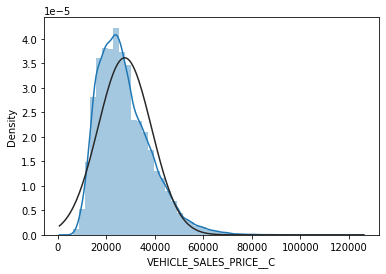

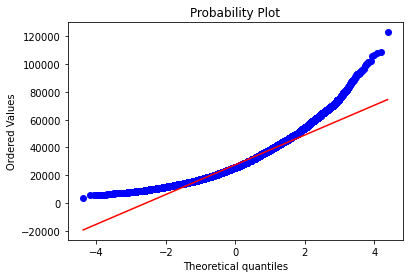

In [21]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(y,fit=norm);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

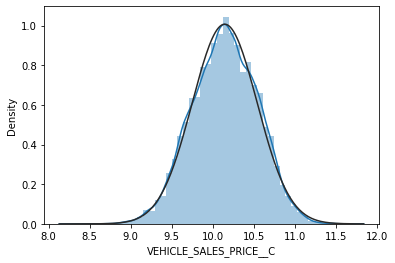

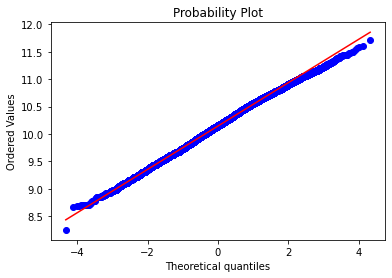

In [22]:
sns.distplot(y_train_log,fit=norm);
fig = plt.figure()
res = stats.probplot(y_train_log, plot=plt)


In [ ]:
df = pd.DataFrame(cars.groupby(['enginetype'])['price'].mean().sort_values(ascending = False))
df.plot.bar(figsize=(8,6))
plt.title('Engine Type vs Average Price')
plt.show()

<AxesSubplot:xlabel='DRIVE_TYPE__C', ylabel='VEHICLE_SALES_PRICE__C'>

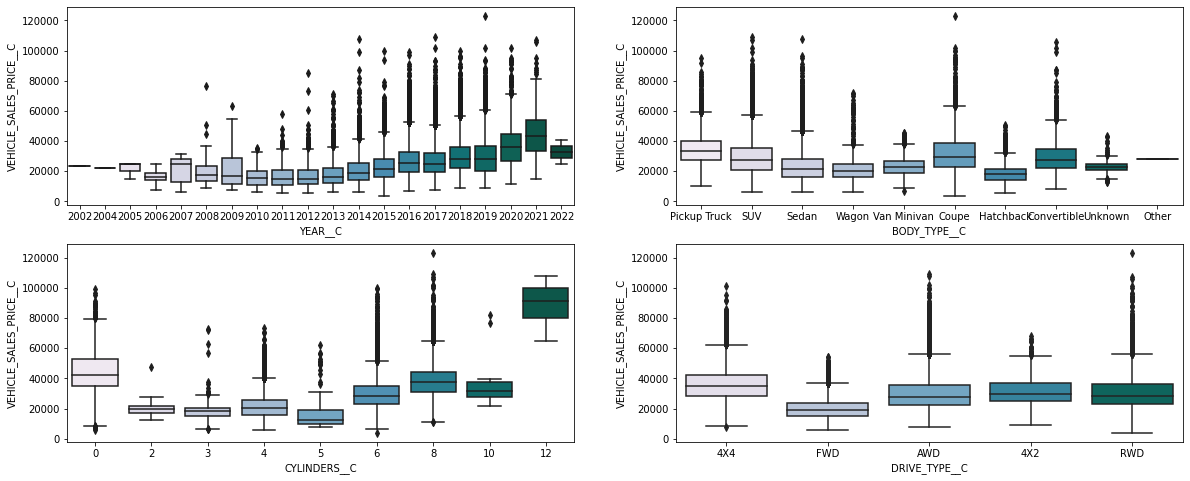

In [25]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.boxplot(x=df.YEAR__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))

plt.subplot(2,2,2)
sns.boxplot(x=df.BODY_TYPE__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))

plt.subplot(2,2,3)
sns.boxplot(x=df.CYLINDERS__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))

plt.subplot(2,2,4)
sns.boxplot(x=df.DRIVE_TYPE__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))

<AxesSubplot:xlabel='EXTERIOR_COLOR__C', ylabel='VEHICLE_SALES_PRICE__C'>

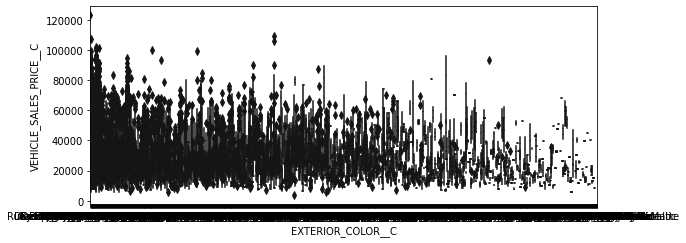

In [26]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.boxplot(x=df.EXTERIOR_COLOR__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))

<AxesSubplot:xlabel='TITLE_STATE__C', ylabel='VEHICLE_SALES_PRICE__C'>

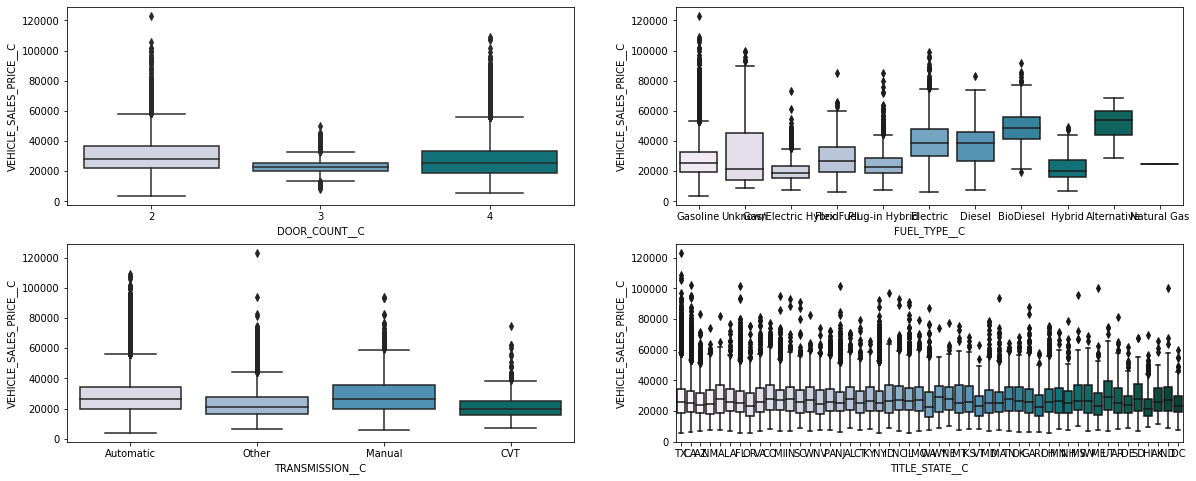

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.boxplot(x=df.DOOR_COUNT__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))
plt.subplot(2,2,2)
sns.boxplot(x=df.FUEL_TYPE__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))
plt.subplot(2,2,3)
sns.boxplot(x=df.TRANSMISSION__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))
plt.subplot(2,2,4)
sns.boxplot(x=df.TITLE_STATE__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))

<AxesSubplot:xlabel='PREVIOUS_OWNER_TYPE__C', ylabel='VEHICLE_SALES_PRICE__C'>

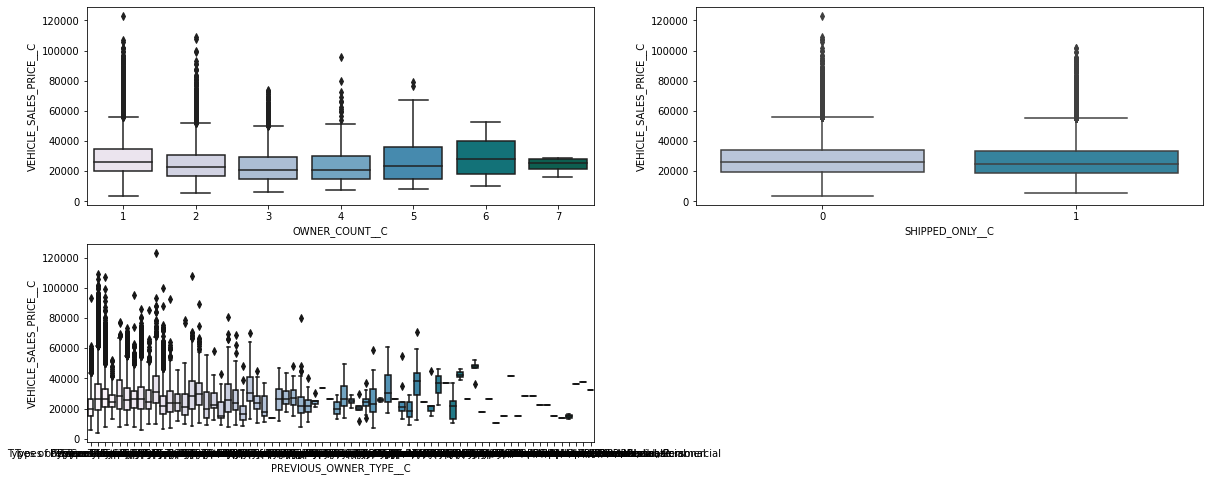

In [29]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
sns.boxplot(x=df.OWNER_COUNT__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))
plt.subplot(2,2,2)
sns.boxplot(x=df.SHIPPED_ONLY__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))
plt.subplot(2,2,3)
sns.boxplot(x=data_raw.PREVIOUS_OWNER_TYPE__C, y=df.VEHICLE_SALES_PRICE__C, palette=("PuBuGn"))


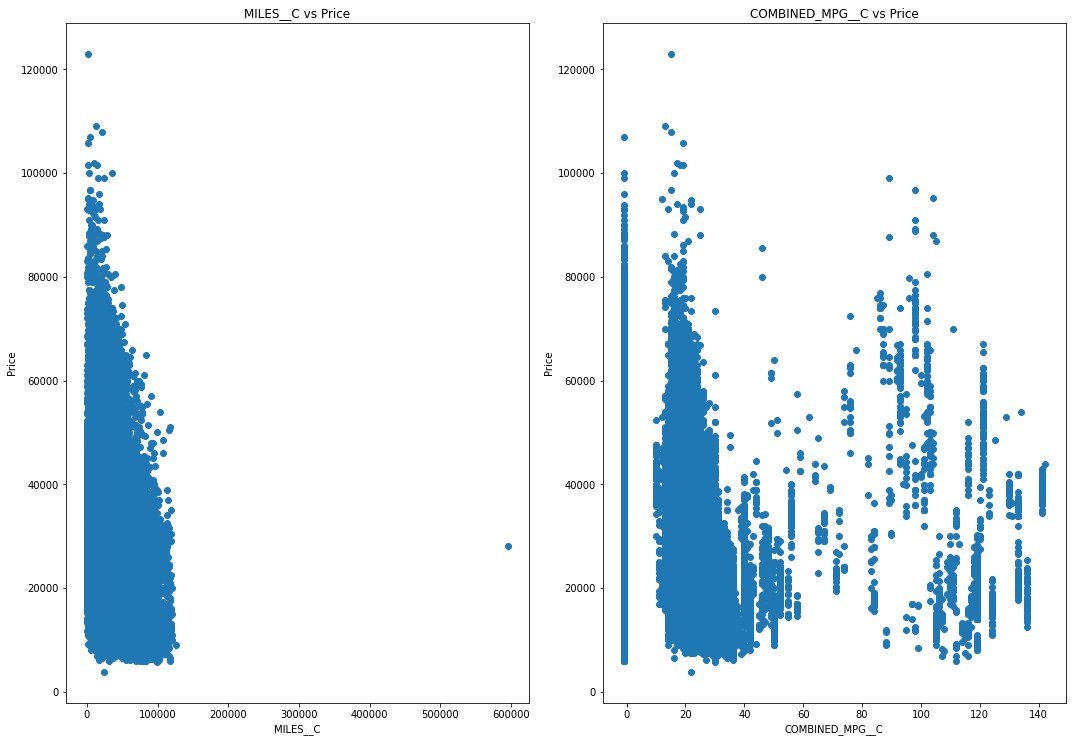

In [37]:
def scatter(x,fig):
    plt.subplot(2,2,fig)
    plt.scatter(df[x],df['VEHICLE_SALES_PRICE__C'])
    plt.title(x+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

plt.figure(figsize=(15,20))

scatter('MILES__C', 1)
scatter('COMBINED_MPG__C', 2)


plt.tight_layout()

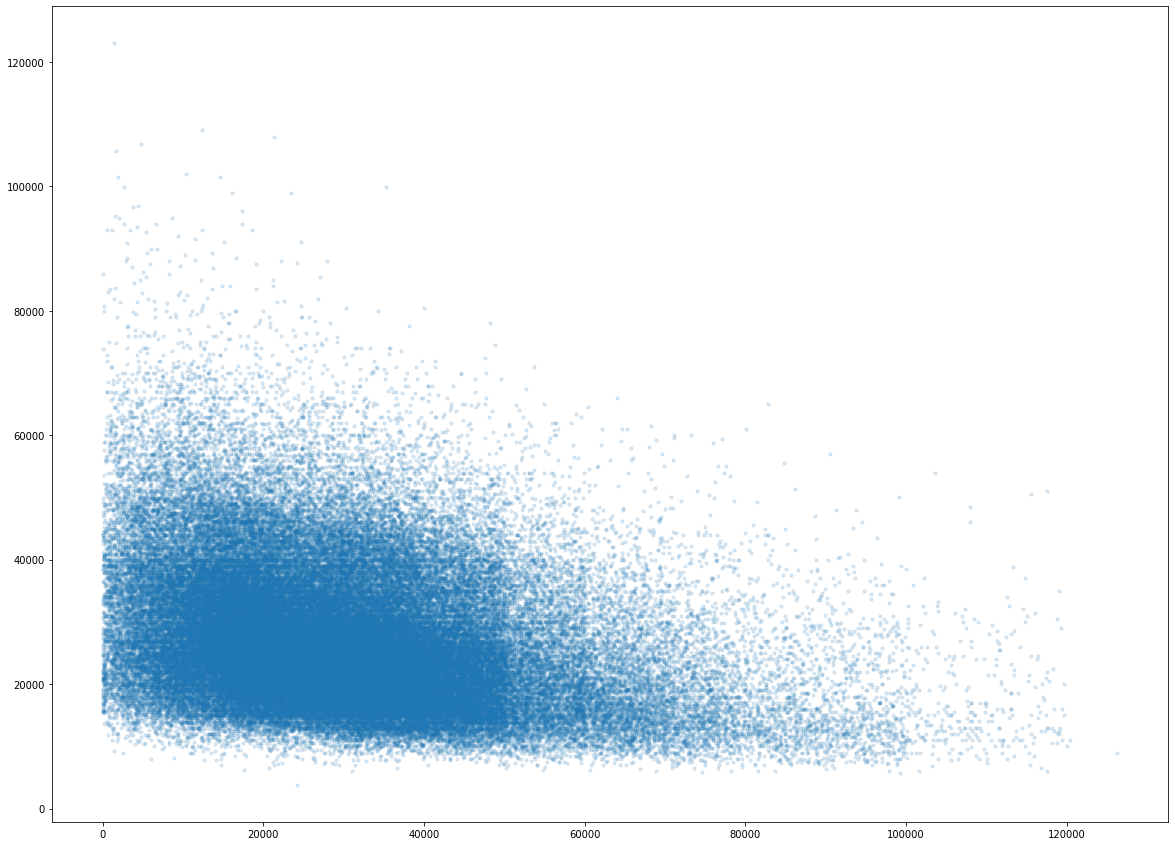

In [44]:
#plot without outlier
plt.figure(figsize=(20,15))
temp = df.loc[df['MILES__C']!=df['MILES__C'].max()]
plt.scatter(temp['MILES__C'],temp['VEHICLE_SALES_PRICE__C'],s = 10, alpha = 0.15)

In [17]:
df.columns

Index(['YEAR__C', 'MAKE__C', 'MODEL__C', 'MILES__C', 'BODY_TYPE__C',
       'CYLINDERS__C', 'DRIVE_TYPE__C', 'EXTERIOR_COLOR__C',
       'INTERIOR_COLOR__C', 'DOOR_COUNT__C', 'FUEL_TYPE__C', 'TRANSMISSION__C',
       'TRIM__C', 'COMBINED_MPG__C', 'TITLE_STATE__C', 'OWNER_COUNT__C',
       'SHIPPED_ONLY__C', 'ELIGIBLE_FOR_LIMITED_WARRANTY__C',
       'VEHICLE_SALES_PRICE__C', 'MODEL_TRIM', 'MAKE_MODEL_TRIM',
       'PreOwner_personal', 'PreOwner_lease', 'PreOwner_rental',
       'PreOwner_corporate', 'PreOwner_commercial', 'PreOwner_taxi',
       'PreOwner_government', 'VIN_1', 'VIN_2', 'VIN_3', 'VIN_4-8', 'VIN_10',
       'VIN_11'],
      dtype='object')